In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
from models import *
from data.data_classes import *

%matplotlib inline

## Data configs

In [ ]:
index = 0
num_ctx_frames = 5
num_tgt_frames = 5

batch_size = 4
action_types = "flipped_jumpingjack"
weizmann = WeizmannDataModule(batch_size, num_ctx_frames, num_tgt_frames,
                              action_types=action_types)

weizmann.setup()
val_dl = weizmann.val_dataloader()
val_ctx_frames, val_tgt_frames = next(iter(val_dl))                            

## Model Configs

In [ ]:
hid_s=64
hid_t=256
N_s=4
N_t=8
kernel_sizes=[3,5,7,11]
groups=4

channels = 3
height = 144
width = 180
input_shape = (channels, num_ctx_frames, height, width)

model_ckpt = Path("./logs/SimVP/experiment1/checkpoints/epoch=99-step=900.ckpt")

model1 = SimVP(input_shape=input_shape, 
               hid_s=hid_s, hid_t=hid_t, 
               N_s=N_s, N_t=N_t,
               kernel_sizes=kernel_sizes, 
               groups=groups)
            
model1 = model1.load_from_checkpoint(model_ckpt)
model1_pred_frames = model1(val_ctx_frames)


In [ ]:
hid_s=64
hid_t=256
N_s=4
N_t=8
kernel_sizes=[3,5,7,11]
groups=4

channels = 3
height = 144
width = 180
input_shape = (channels, num_ctx_frames, height, width)

model_ckpt = Path("./logs/SimVP/experiment2/checkpoints/epoch=99-step=900.ckpt")

model2 = SimVP(input_shape=input_shape, 
               hid_s=hid_s, hid_t=hid_t, 
               N_s=N_s, N_t=N_t,
               kernel_sizes=kernel_sizes, 
               groups=groups)
            
model2 = model2.load_from_checkpoint(model_ckpt)
model2_pred_frames = model2(val_ctx_frames)


In [ ]:
def make_thesis_plot(frame_sets, names, plot_height):

    def show_frames(frames, ax, start_id, row_label=None):
        for i, frame in enumerate(frames):
            ax[i].imshow(frame)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_xlabel(f"t={start_id+i}")
            ax[i].xaxis.set_label_coords(.52, 1.15)

        if row_label is not None:
            ax[0].set_ylabel(row_label)

    fig, ax = plt.subplots(len(frame_sets), 5,
                               figsize = (9, plot_height))
    # fig.suptitle("Weizmann", y=0.93)

    for i, frames in enumerate(frame_sets):
        start_id = 1 if i == 0 else 6
        frames = frames.squeeze().permute(1, 2, 3, 0).cpu().detach().numpy()
        show_frames(frames, ax[i], start_id, names[i])
    fig.set_facecolor("white")

    return fig

In [ ]:
frame_sets = [val_ctx_frames[index], 
              val_tgt_frames[index],
              model1_pred_frames[index],
              model2_pred_frames[index]]

names = ["Context", "Target", "SimVP (MSE)", "SimVP (L1)"]               
make_thesis_plot(frame_sets, names, plot_height=5)

### 1 to 9 plot

In [3]:
index = 0
num_ctx_frames = 1
num_tgt_frames = 9

batch_size = 4
action_types = "flipped_jumpingjack"
weizmann = WeizmannDataModule(batch_size, num_ctx_frames, num_tgt_frames,
                              action_types=action_types)

weizmann.setup()
val_dl = weizmann.val_dataloader()
val_ctx_frames, val_tgt_frames = next(iter(val_dl))                            

In [4]:
hid_s=64
hid_t=256
N_s=4
N_t=8
kernel_sizes=[3,5,7,11]
groups=4

channels = 3
height = 144
width = 180
input_shape = (channels, num_ctx_frames, height, width)

model_ckpt = "./logs/SimVP_1to9/experiment3/checkpoints/epoch=99-step=900.ckpt"

model1 = SimVP_1to9(input_shape=input_shape, 
                    hid_s=hid_s, hid_t=hid_t, 
                    N_s=N_s, N_t=N_t,
                    kernel_sizes=kernel_sizes, 
                    groups=groups)
            
model1 = model1.load_from_checkpoint(model_ckpt)
model1_pred_frames = torch.zeros_like(val_tgt_frames)
model1_pred_frames[:, :, 0] = model1(val_ctx_frames).squeeze()

for i in range(1, val_tgt_frames.shape[2]):
    print(i)
    ctx_frames = model1_pred_frames[:, :, i-1].unsqueeze(dim=2).detach()
    model1_pred_frames[:, :, i] = model1(ctx_frames).squeeze()

1
2
3
4
5
6
7
8


In [6]:
hid_s=64
hid_t=256
N_s=4
N_t=8
kernel_sizes=[3,5,7,11]
groups=4

channels = 3
height = 144
width = 180
input_shape = (channels, num_ctx_frames, height, width)

model_ckpt = "./logs/SimVP_1to9/experiment4/checkpoints/epoch=99-step=900.ckpt"

model2 = SimVP_1to9(input_shape=input_shape, 
                    hid_s=hid_s, hid_t=hid_t, 
                    N_s=N_s, N_t=N_t,
                    kernel_sizes=kernel_sizes, 
                    groups=groups)
            
model2 = model2.load_from_checkpoint(model_ckpt)
model2_pred_frames = torch.zeros_like(val_tgt_frames)
model2_pred_frames[:, :, 0] = model2(val_ctx_frames).squeeze()

for i in range(1, val_tgt_frames.shape[2]):
    print(i)
    ctx_frames = model2_pred_frames[:, :, i-1].unsqueeze(dim=2).detach()
    model2_pred_frames[:, :, i] = model2(ctx_frames).squeeze()

1
2
3
4
5
6
7
8


In [7]:
def make_thesis_plot_1to9(frames_sets, names, plot_height):

    def show_frames(frames, ax, row_label=None):
        if len(frames) == 9:
            start_id = 1  
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            ax.imshow(np.zeros_like(frames[0]))
        else:
            start_id = 0
        
        for i, frame in enumerate(frames):
            ax[start_id + i].imshow(frame)
            ax[start_id + i].set_xticks([])
            ax[start_id + i].set_yticks([])
            ax[start_id + i].set_xlabel(f"t={start_id + i}")
            ax[start_id + i].xaxis.set_label_coords(.52, 1.15)

        if row_label is not None:
            ax[0].set_ylabel(row_label)

    fig, ax = plt.subplots(len(frame_sets), 10,
                               figsize = (16, plot_height))

    for i, frames in enumerate(frame_sets):
        print(frames.shape)
        frames = frames.permute(1, 2, 3, 0).cpu().detach().numpy()
        show_frames(frames, ax[i], names[i])
    fig.set_facecolor("white")

    return fig

In [8]:
val_ctx_frames.shape
torch.concat((val_ctx_frames, val_tgt_frames), dim=2).shape

torch.Size([4, 3, 10, 144, 180])

torch.Size([3, 10, 144, 180])
torch.Size([3, 9, 144, 180])
torch.Size([3, 9, 144, 180])


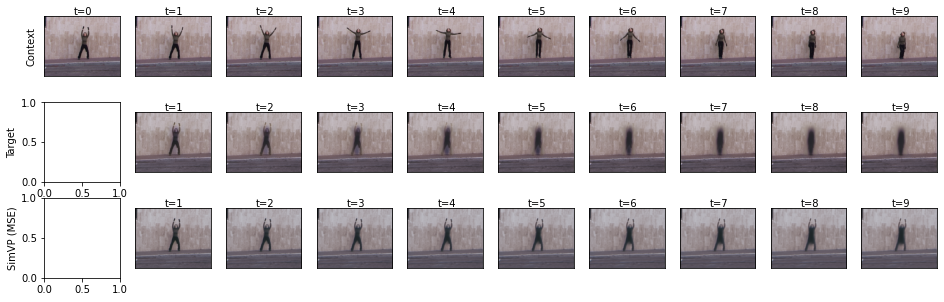

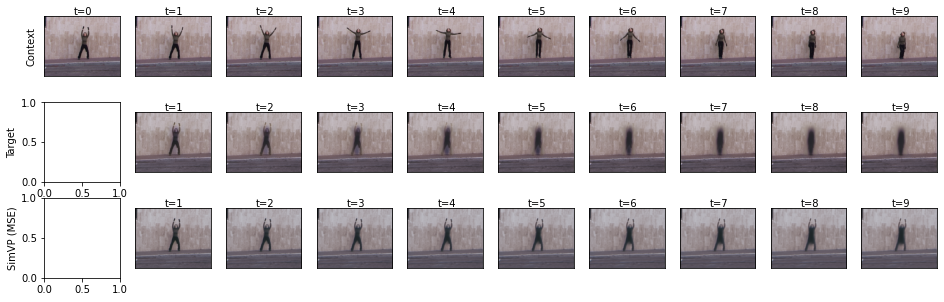

: 

In [9]:
frame_sets = [torch.concat((val_ctx_frames, val_tgt_frames), dim=2)[index],
              model1_pred_frames[index],
              model2_pred_frames[index]]

names = ["Context", "Target", "SimVP (MSE)", "SimVP (L1)"]               
make_thesis_plot_1to9(frame_sets, names, plot_height=5)

In [ ]:
model1_pred_frames.shape